In [ ]:
# Customer Churn Prediction:
# In this project, we aim to predict customer churn (1 = churn, 0 = not churn) for an e-commerce company using XGBoost.

#  By learning from historical customer data such as tenure, complaints, satisfaction scores, and order history, the model forecasts which customers are likely to leave.

# This helps the business take proactive actions (e.g., retention offers) to reduce churn and improve customer loyalty.I have further used Shapleys Additve for XAI

In [30]:
!pip install --quiet xgboost shap scikit-learn matplotlib seaborn pandas joblib  imbalanced-learn

In [4]:
 from google.colab import files

 uploaded = files.upload()

Saving data_ecommerce_customer_churn.csv to data_ecommerce_customer_churn.csv


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#Importing necessary packages


In [6]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

import xgboost as xgb
import joblib

In [7]:
df=pd.read_csv('data_ecommerce_customer_churn.csv')

In [6]:
df.head()

,Tenure,WarehouseToHome,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,DaySinceLastOrder,CashbackAmount,Churn
0,15.0,29.0,4,Laptop & Accessory,3,Single,2,0,7.0,143.32,0
1,7.0,25.0,4,Mobile,1,Married,2,0,7.0,129.29,0
2,27.0,13.0,3,Laptop & Accessory,1,Married,5,0,7.0,168.54,0
3,20.0,25.0,4,Fashion,3,Divorced,7,0,NaN,230.27,0
4,30.0,15.0,4,Others,4,Single,8,0,8.0,322.17,0


In [15]:
print("Missing values:\n", df.isna().sum()) #data quality checks


Missing values:
 Tenure                      194
WarehouseToHome             169
NumberOfDeviceRegistered      0
PreferedOrderCat              0
SatisfactionScore             0
MaritalStatus                 0
NumberOfAddress               0
Complain                      0
DaySinceLastOrder           213
CashbackAmount                0
Churn                         0
dtype: int64


In [16]:
#Data Cleaning

df['Tenure'].fillna(df['Tenure'].median(), inplace=True)  #Filling  tenure with mediam
df['WarehouseToHome'].fillna(df['WarehouseToHome'].median(), inplace=True)# filling warehouse to home with median
df['HourSpendOnApp'].fillna(0, inplace=True) #probably no record never ordered so imputing 0

/tmp/ipython-input-1106823058.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Tenure'].fillna(df['Tenure'].median(), inplace=True)  #Filling  tenure with mediam
/tmp/ipython-input-1106823058.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col

KeyError: 'HourSpendOnApp'

In [19]:
print("Duplicates:", df.duplicated().sum())  #data quality checks

Duplicates: 0


In [18]:
df=df.drop_duplicates()

In [23]:

print("Shape:", df.shape)


Shape: (3270, 11)


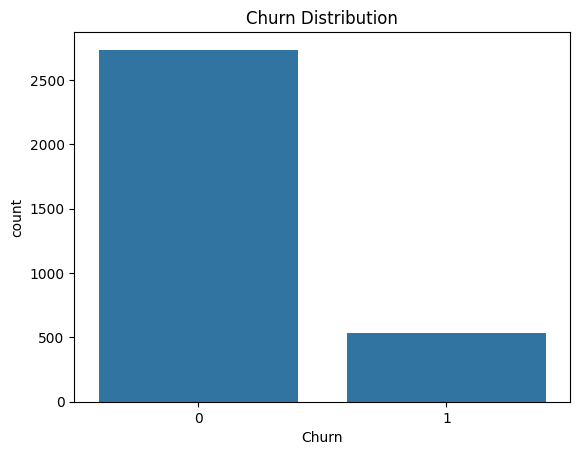

In [29]:
sns.countplot(x='Churn', data=df)
plt.title('Churn Distribution')
plt.show()    #highly imbalanced data 83 percent to 17 percent

In [24]:
print(df['Churn'].value_counts(normalize=True))

Churn
0    0.836697
1    0.163303
Name: proportion, dtype: float64


In [28]:
TARGET = 'Churn'
X = df.drop(columns=[TARGET])
y = df[TARGET]
# target is y

In [26]:
# doing train test spliut with test size 0.2 and stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)

Train shape: (2616, 10) Test shape: (654, 10)


In [35]:
#pre processing before pipeline

numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numeric:", numeric_features)
print("Categorical:", categorical_features)



Numeric: ['Tenure', 'WarehouseToHome', 'NumberOfDeviceRegistered', 'SatisfactionScore', 'NumberOfAddress', 'Complain', 'DaySinceLastOrder', 'CashbackAmount']
Categorical: ['PreferedOrderCat', 'MaritalStatus']


In [36]:
#Pipeline

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [52]:
#creating xgb variable

# scale_pos_weight = (negatives / positives)
#to handle class imbalance so that underrepresenated class (churners)is given more wt
#during training and does not default to predict majoiry class

#give 4.88 x more focus
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',   # logistic loss
    use_label_encoder=False,
    eval_metric='logloss',    # binary cross entropy as binary classification
    n_jobs=-1,
    random_state=42
)




In [53]:
# combination of pipeline and  xgblassifier
clf_pipe = Pipeline(steps=[('pre', preprocessor), ('clf', xgb_clf)])

In [54]:
clf_pipe.fit(X_train, y_train)
y_proba = clf_pipe.predict_proba(X_test)[:,1]

print("Baseline ROC AUC:", roc_auc_score(y_test, y_proba)) # predict proba of postive class along with ground truth


Baseline ROC AUC: 0.9586529754480685


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:51:54] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


HYPER PARAMETER *TUNING*

In [55]:



param_dist = {
    'clf__n_estimators': [100, 200, 300, 500],   # number of trees
    'clf__learning_rate': [0.01, 0.05, 0.1],     # shrinkage step
    'clf__max_depth': [3, 4, 5, 6, 8],           # depth of trees
    'clf__min_child_weight': [1, 3, 5],          # min hessian sum per leaf
    'clf__gamma': [0, 0.1, 0.3, 0.5],            # min loss reduction to split
    'clf__subsample': [0.6, 0.8, 1.0],           # row sampling
    'clf__colsample_bytree': [0.6, 0.8, 1.0],    # feature sampling
    'clf__reg_alpha': [0, 0.1, 0.5],             # L1 regularization
    'clf__reg_lambda': [1, 1.5, 2]               # L2 regularization
}


In [56]:
# n_estimators = number of boosting rounds (too high → overfit if no early stopping).

# learning_rate (eta) = shrinkage factor. Small → more stable, need more trees.
#  complex splits can be.

# min_child_weight = prevents overfitting tiny leaves .
#Tree is more conservative if higher as it will need more samples

# gamma = min loss reduction → higher = conservative as loss threshold is higherubsample = fraction of rows

# colsample_bytree = fraction of features per tree.

# reg_alpha (L1) & reg_lambda (L2) = penalties to shrink weights.

In [57]:
rs = RandomizedSearchCV(
    estimator=clf_pipe,
    param_distributions=param_dist,
    n_iter=40,            # trying 40 random combos
    scoring='roc_auc',
    cv=3,                # 3 fold cross validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

rs.fit(X_train, y_train)
print("Best AUC:", rs.best_score_)
print("Best Params:", rs.best_params_)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
Best AUC: 0.920297602471995
Best Params: {'clf__subsample': 0.6, 'clf__reg_lambda': 1, 'clf__reg_alpha': 0.5, 'clf__n_estimators': 300, 'clf__min_child_weight': 1, 'clf__max_depth': 8, 'clf__learning_rate': 0.05, 'clf__gamma': 0.5, 'clf__colsample_bytree': 0.6}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:52:19] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [58]:
best_pipe = rs.best_estimator_
y_proba = best_pipe.predict_proba(X_test)[:,1]  #probabilities for class 1
y_pred = (y_proba >= 0.5).astype(int)
print("Test ROC AUC:", roc_auc_score(y_test, y_proba)) # ground truth and y prob
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Test ROC AUC: 0.9597122793828701

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.95       547
           1       0.78      0.72      0.75       107

    accuracy                           0.92       654
   macro avg       0.86      0.84      0.85       654
weighted avg       0.92      0.92      0.92       654


Confusion Matrix:
 [[525  22]
 [ 30  77]]


In [59]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve


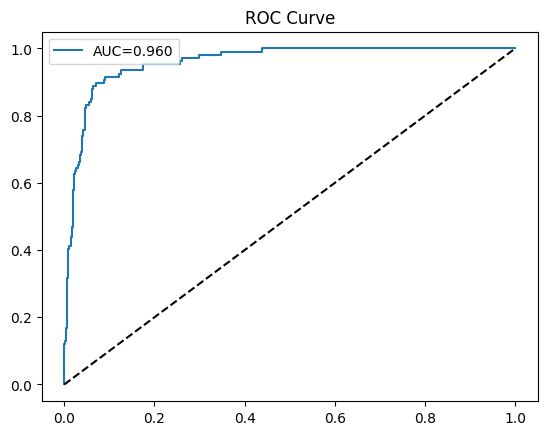

In [60]:
# ROC Curve almost 0.96 indicting high class separation ability
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}")
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curve")
plt.legend(); plt.show()

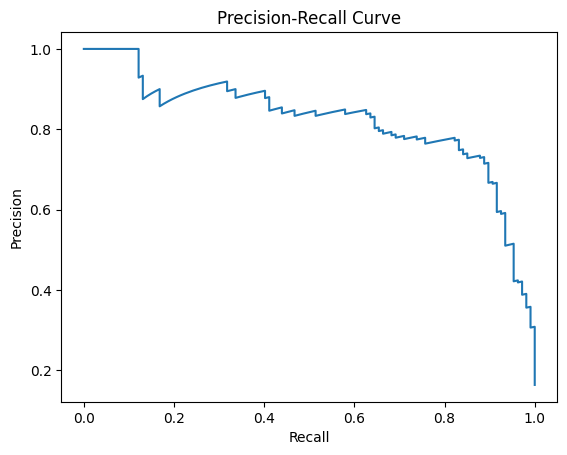

In [61]:
# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_proba)
plt.plot(rec, prec)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.show()

In [ ]:
# # At Recall = 0.4, the model only identifies 40% of churners.
# The precision is very high at this point, meaning most flagged customers truly are churners.
#  Business-wise, this threshold minimizes wasted offers, but many churners are still missed.
# If our goal is to save more customers, we’d shift to a threshold that increases recall, even at the cost of some precision

In [66]:
from sklearn.metrics import fbeta_score

# We can further  Evaluate at different  thresholds
#lets say 0.4
# i can evenn tweak beta to give more importance to precison less than 1
#Or recall more than 1

yred = (y_proba >= 0.4).astype(int)

print("F0.5:", fbeta_score(y_test, y_pred, beta=0.5))
print("F1:", fbeta_score(y_test, y_pred, beta=1))
print("F1.5:", fbeta_score(y_test, y_pred, beta=1.5))
print("F2:", fbeta_score(y_test, y_pred, beta=2))

F0.5: 0.7739130434782608
F1: 0.7946428571428571
F1.5: 0.8085255066387141
F2: 0.8165137614678899


In [75]:
#getting feature names back from pre processing stage
feature_names = best_pipe.named_steps['pre'].get_feature_names_out().tolist()# from array to list


In [76]:
# Xg boost   inbuilt feature importance
# get booster extracts the trained xg booster object (the internal model with trees)
booster = best_pipe.named_steps['clf'].get_booster()

booster.feature_names = feature_names


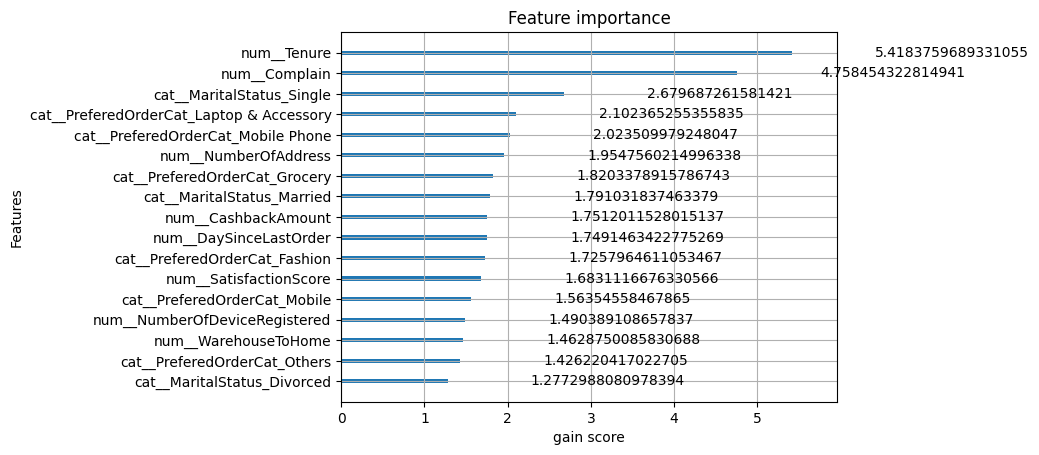

In [79]:

# Plotting feautre importances

# Importances can be gain value cover
xgb.plot_importance(booster, importance_type="gain", xlabel="gain score")
plt.show()

In [ ]:
# Weight

# Counts how many times a feature was used for splitting.



# Gain

# Measures how much a feature improved the model (loss reduction) when used for a split.


# Cover

# Measures how many samples were affected by splits using this feature.



# Gain is usually the best measure of importance. hence plotted it

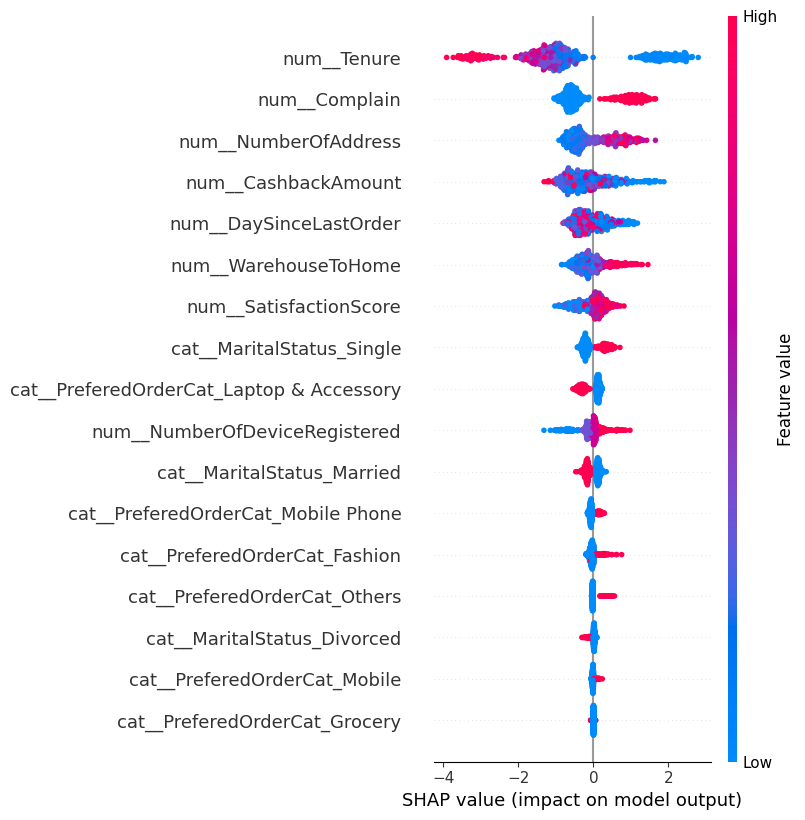

In [80]:
import shap

# Getting trained xg boost model from pipeline

model = best_pipe.named_steps['clf']

# Transforming my  test data (so features are numeric & encoded)
X_test_trans = best_pipe.named_steps['pre'].transform(X_test)
feature_names = best_pipe.named_steps['pre'].get_feature_names_out()

 #Creatting SHAP explainer

explainer = shap.TreeExplainer(model)

#  Calculating SHAP values for the test set
shap_values = explainer(X_test_trans)

#Global summary plot (what  is driing churn overall)

shap.summary_plot(shap_values, X_test_trans, feature_names=feature_names)

# Local explanation one customer in case i want to see
# shap.plots.waterfall(shap_values[0], feature_names=feature_names)


My takeaways

## 📌 Project Summary: Customer Churn Prediction with XGBoost + SHAP

- **Objective:** Predict customer churn (1 = churn, 0 = not churn) for an e-commerce company.  
- **Model:** XGBoost Classifier, tuned with cross-validation.  
- **Evaluation Metrics:** AUC-ROC (0.96, indicating strong class separation), Precision-Recall curve (to handle class imbalance).  
- **Key Features Driving Churn (SHAP):**
  - **Tenure:** Shorter tenure → higher churn risk; long-term customers are more loyal.  
  - **Complaints:** More complaints strongly increase churn likelihood.  
  - **Satisfaction Score:** Higher satisfaction reduces churn; dissatisfied customers are at risk.  
  - **Number of Addresses:** Multiple addresses linked with unstable or less loyal customers.  

### 🔹 Business Takeaways
- **Retention Strategy:** Focus retention offers on customers with low tenure, frequent complaints, and low satisfaction.  
- **Actionable Insight:** Loyalty rewards for long-tenure customers, proactive resolution for complaints, and monitoring customers with unstable profiles.  
- **Explainability:** SHAP provided both global insights (what drives churn overall) and local insights (why a specific customer is predicted to churn).  

This ensures my  model is not a black box but provides **transparent, actionable AI for business decisions.**

